In [1]:
import pandas as pd
import numpy as np

import skfuzzy as fuzz
from skfuzzy import control as ctrl

from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

import networkx as nx
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz

pd.set_option('display.precision', 3);
%matplotlib inline

# 1. Подготовка

## 1.1. Загрузка данных

In [2]:
data = pd.read_csv('ccpp.csv', # путь к файлу,
                   sep=';', # разделитель данных в файле
                   decimal=",",# дробная часть отделяется запятой
                   header=0) # номер строки с заголовками

data.columns = ([u'Temperature', u'Vacuum', u'Pressure',u'Humidity', u'EnergyOutput'])

In [3]:
features = [u'Temperature', u'Vacuum']
target = [u'EnergyOutput']

In [4]:
data.shape

(9568, 5)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
Temperature     9568 non-null float64
Vacuum          9568 non-null float64
Pressure        9568 non-null float64
Humidity        9568 non-null float64
EnergyOutput    9568 non-null float64
dtypes: float64(5)
memory usage: 373.8 KB


In [6]:
data.describe(include='all') 

,Temperature,Vacuum,Pressure,Humidity,EnergyOutput
count,9568.000,9568.000,9568.000,9568.000,9568.000
mean,19.651,54.306,1013.259,73.309,454.365
std,7.452,12.708,5.939,14.600,17.067
min,1.810,25.360,992.890,25.560,420.260
25%,13.510,41.740,1009.100,63.328,439.750
50%,20.345,52.080,1012.940,74.975,451.550
75%,25.720,66.540,1017.260,84.830,468.430
max,37.110,81.560,1033.300,100.160,495.760


In [7]:
data_origin = data

## 1.2. Коэфф. корреляции

In [8]:
corr_matrix_all = data.corr()

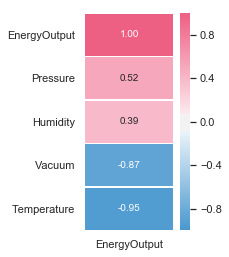

In [9]:
# цветовая карта
p = sns.diverging_palette(240, # HSV тон положительного
                          0,   # HSV тон отрицательного
                          s=80, # насыщенность.
                          l=60, # яркость
                          sep=20, # ширина центральной "нечувствительной" области
                          n=6,
                          center='light',
                          as_cmap=True)

plt.figure(figsize=(2,4))

# выбор столбца матрицы корреляции с значениями для целевой переменной 
corr_sorted = corr_matrix_all[ target ] \
  .sort_values(target, axis=0, ascending=False) # сортировка значений

# вывод в виде тепловой карты
sns.heatmap(
   data=corr_sorted,  # данные
   cmap=p,  # цветовая карта
   annot=True, # вывод значений
   fmt=".2f", # формат вывода значений
   vmin=-1, vmax=1, # граничные значения для цветовой карты 
   linewidths=.5, # расстояние между ячейками
);

# 2. Модель нечеткой логики

# 2.1 Описание

Определим граничные значения диапазонов для выбранных независимых признаков и целевой переменной.

In [10]:
pd.concat( [ 
        data[features+target].min(),
        data[features+target].max(),
    ],
    axis=1,
    keys=['min', 'max'])

,min,max
Temperature,1.81,37.11
Vacuum,25.36,81.56
EnergyOutput,420.26,495.76


# 2.2. Формирование базового набора ЛП

In [11]:
print "Входные (Antecedent - посылка)"
for i in range(0, len(features)):
    print "  {} - Универс: [{}, {}]".format(features[i], data[features].min()[i], data[features].max()[i])
print ""   
print "Выходные (Consequent - заключение)"
print "  {} - Универс: [{}, {}]".format(target[0], data[target].min()[0], data[target].max()[0])

Входные (Antecedent - посылка)
  Temperature - Универс: [1.81, 37.11]
  Vacuum - Универс: [25.36, 81.56]

Выходные (Consequent - заключение)
  EnergyOutput - Универс: [420.26, 495.76]


In [12]:
# посылка - Temperature [1.81, 37.11]
temperature_un = np.arange(1.81, 37.11+0.01, 0.01)
lv_temperature = ctrl.Antecedent(temperature_un, "Temperature")

# посылка - Vacuum  [25.36, 81.56]
vacuum_un = np.arange(25.36, 81.56+0.01, 0.01)
lv_vacuum = ctrl.Antecedent(vacuum_un, "Vacuum")

# заключение - EnergyOutput [420.26, 495.76]
energyoutput_un = np.arange(420.26,  495.76+0.01, 0.01)
lv_energyoutput = ctrl.Consequent(energyoutput_un, "EnergyOutput")

In [13]:
print "*", len(lv_temperature.universe),     lv_temperature.label,     lv_temperature.universe
print "*", len(lv_vacuum.universe),     lv_vacuum.label,     lv_vacuum.universe
print "*", len(lv_energyoutput.universe),     lv_energyoutput.label,     lv_energyoutput.universe

* 3531 Temperature [ 1.81  1.82  1.83 ... 37.09 37.1  37.11]
* 5622 Vacuum [25.36 25.37 25.38 ... 81.55 81.56 81.57]
* 7551 EnergyOutput [420.26 420.27 420.28 ... 495.74 495.75 495.76]


# 2.3. Формирование базовых терм-множеств

### 2.3.2. Формирование терм-множеств

## Итерация 1

c:\python27\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


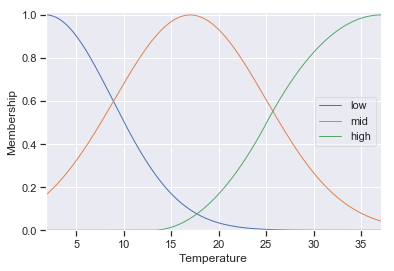

In [14]:
#Temperature
lv_temperature["low"] = fuzz.gaussmf(lv_temperature.universe, 1.81, 7)
lv_temperature["mid"] = fuzz.gaussmf(lv_temperature.universe, 17, 8)
lv_temperature["high"] = fuzz.smf(lv_temperature.universe,13, 37.11)
lv_temperature.view()

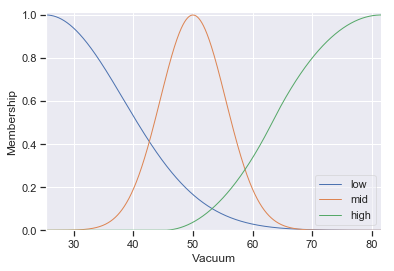

In [15]:
#Vacuum
lv_vacuum["low"] = fuzz.gaussmf(lv_vacuum.universe, 25.36, 13)
lv_vacuum["mid"] = fuzz.gaussmf(lv_vacuum.universe, 50, 5.5)
lv_vacuum["high"] = fuzz.smf(lv_vacuum.universe,45, 81.57)
lv_vacuum.view()

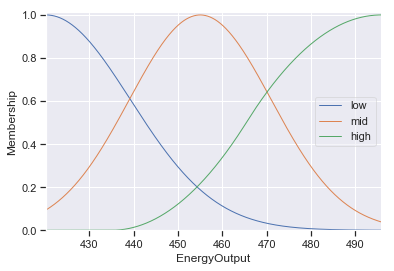

In [16]:
#EnergyOutput
lv_energyoutput["low"] = fuzz.gaussmf(lv_energyoutput.universe, 420.26, 19)
lv_energyoutput["mid"] = fuzz.gaussmf(lv_energyoutput.universe, 455,16)
lv_energyoutput["high"] = fuzz.smf(lv_energyoutput.universe, 435, 495.76)
lv_energyoutput.view()

## 2.4. Формирование нечеткой базы знаний

In [17]:
#1) ЕСЛИ () ИЛИ (), ТО ().
rule_1 = ctrl.Rule(
lv_temperature["low"] & lv_vacuum["low"] ,
lv_energyoutput["high"],
"firstRule")

In [18]:
#2) ЕСЛИ () ИЛИ (), ТО ().
rule_2 = ctrl.Rule(
lv_temperature["low"] & lv_vacuum["mid"] ,
lv_energyoutput["mid"],
"secondRule")

In [19]:
#3) ЕСЛИ () ИЛИ (), ТО ().
rule_3 = ctrl.Rule(
lv_temperature["mid"] & lv_vacuum["mid"] ,
lv_energyoutput["mid"],
"thirdRule")

In [20]:
#4) ЕСЛИ () ИЛИ (), ТО ().
rule_4 = ctrl.Rule(
lv_temperature["high"] & lv_vacuum["high"] ,
lv_energyoutput["low"],
"forthRule")

In [21]:
#5) ЕСЛИ () ИЛИ (), ТО ().
rule_5 = ctrl.Rule(
lv_temperature["mid"] & lv_vacuum["low"] ,
lv_energyoutput["mid"],
"fifthRule")

In [22]:
#6) ЕСЛИ () ИЛИ (), ТО ().
rule_6 = ctrl.Rule(
lv_temperature["high"] & lv_vacuum["mid"] ,
lv_energyoutput["low"],
"sixfthRule")

In [23]:
#7) ЕСЛИ () ИЛИ (), ТО ().
rule_7 = ctrl.Rule(
lv_temperature["mid"] & lv_vacuum["high"] ,
lv_energyoutput["mid"],
"sevnthRule")

In [24]:
#8) ЕСЛИ () ИЛИ (), ТО ().
rule_8 = ctrl.Rule(
lv_temperature["low"] & lv_vacuum["high"] ,
lv_energyoutput["high"],
"eightRule")

## 2.5. Тестирование нечеткой базы знаний

### 2.5.1. Этап подготовки

In [25]:
quality_ctrl = ctrl.ControlSystem([rule_1, rule_2, rule_3, rule_4, rule_5, rule_6, rule_7, rule_8])
quality_SIM = ctrl.ControlSystemSimulation(quality_ctrl)

In [26]:
# Создадим функцию для вывода степени вероятности принадлежности переданного значения
def printTerm(lingVal, value):
    print "\n  {:>10} = {:>10}".format(lingVal.label, value[0]),
    for term in lingVal.terms:
        print "{} {:>7} {:.2f},".format(" ", term, fuzz.interp_membership( lingVal.universe, lingVal[term].mf,   value[0])),

Сформируем тестовое множество

In [27]:
valid_size = 0.3 # доля тестовой части в выборке
rand_seed = 8 # начальное состояние генератора случ. чисел

x_train, x_test, y_train, y_test =  train_test_split(
    data[features], data[target], # исходные данные
    test_size = valid_size, 
    random_state=rand_seed, 
    shuffle=True # перемешивание
) 
print "Кол-во элементов: \n  x_train: {}, y_train {} \n  x_test:  {}, y_test  {} \n  total x: {}, total y {} ".format  (
    len(x_train), len(y_train),
    len(x_test),  len(x_test), 
    len(x_train)+len(x_test), len(y_train)+len(x_test),
)

Кол-во элементов: 
  x_train: 6697, y_train 6697 
  x_test:  2871, y_test  2871 
  total x: 9568, total y 9568 


### 2.5.2. Проверка работы модели

In [28]:
print "Вывод значений проверочной части данных"
start_index = 0
stop_index = 2
for i in range(start_index, stop_index):
    print "{}, {}; y:{}".format(
    x_test[features].iloc[i][0],
    x_test[features].iloc[i][1],y_test.iloc[i][0] )

Вывод значений проверочной части данных
12.64, 41.49; y:468.78
27.08, 62.91; y:442.91


In [29]:
in_temperatures = [12.64]
in_vacuumes = [41.49]

quality_SIM.input['Temperature'] = in_temperatures 
quality_SIM.input['Vacuum'] = in_vacuumes

print "Степень принадлежности значений к каждому терму:",
printTerm(lv_temperature, in_temperatures)
printTerm(lv_vacuum, in_vacuumes)

Степень принадлежности значений к каждому терму: 
  Temperature =      12.64       low 0.30,       mid 0.86,      high 0.00, 
      Vacuum =      41.49       low 0.46,       mid 0.30,      high 0.00,


In [30]:
# Вычисление
quality_SIM.compute()

# Вывод результата
print "calc={:,.2f}, real= {:,.2f}  delta={:,.2f}".format (quality_SIM.output['EnergyOutput'], y_test.iloc[1][0], (quality_SIM.output['EnergyOutput'] - y_test.iloc[1][0]))

calc=458.66, real= 442.91  delta=15.75


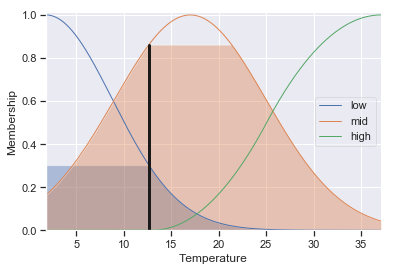

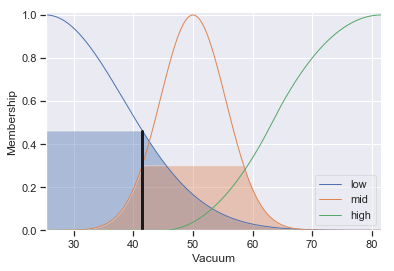

In [31]:
lv_temperature.view(sim=quality_SIM)
lv_vacuum.view(sim=quality_SIM)

Проанализируем ход получения результата

In [32]:
quality_SIM.print_state()

 Antecedents 
Antecedent: Temperature             = [12.64]
  - low                             : [0.30215187]
  - mid                             : [0.86198923]
  - high                            : [0.]
Antecedent: Vacuum                  = [41.49]
  - low                             : [0.46312692]
  - mid                             : [0.30209116]
  - high                            : [0.]

 Rules 
RULE #0:
  IF Temperature[low] AND Vacuum[mid] THEN EnergyOutput[mid]
	AND aggregation function : fmin
	OR aggregation function  : fmax

  Aggregation (IF-clause):
  - Temperature[low]                                       : [0.30215187]
  - Vacuum[mid]                                            : [0.30209116]
                          Temperature[low] AND Vacuum[mid] = [0.30209116]
  Activation (THEN-clause):
                                         EnergyOutput[mid] : [0.30209116]

RULE #1:
  IF Temperature[mid] AND Vacuum[low] THEN EnergyOutput[mid]
	AND aggregation function : fmin
	OR

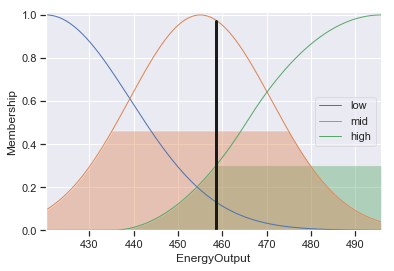

In [33]:
lv_energyoutput.view(sim=quality_SIM)

### 2.5.3. Проверка работы модели на проверочной части выборки

In [34]:
y_pred = np.array([])
start_index = 105
stop_index = 155

for i in range (start_index, stop_index):
    print "row", i,
    
    #очередные значения
    in_temperatures    = x_test[features].iloc[i][0],
    in_vacuum     = x_test[features].iloc[i][1], 
    out_energyoutput   = y_test.iloc[i][0]

    # задать значения в модель нечеткой логики
    quality_SIM.input['Temperature']     = in_temperatures
    quality_SIM.input['Vacuum'] = in_vacuum
    
    print "Степень принадлежности значений к каждому терму:",
    printTerm(lv_temperature, in_temperatures)
    printTerm(lv_vacuum, in_vacuum)
    
    # Вычисление
    quality_SIM.compute()

    # Вывод результата
    y_pred = np.append(y_pred, quality_SIM.output['EnergyOutput'])
    print ""
    print "{} calc={:.2f}, true={:.2f}".format(target[0], quality_SIM.output['EnergyOutput'], out_energyoutput) 
    print ""

row 105 Степень принадлежности значений к каждому терму: 
  Temperature =      15.56       low 0.15,       mid 0.98,      high 0.02, 
      Vacuum =       41.1       low 0.48,       mid 0.27,      high 0.00, 
EnergyOutput calc=456.31, true=464.42

row 106 Степень принадлежности значений к каждому терму: 
  Temperature =      28.98       low 0.00,       mid 0.33,      high 0.77, 
      Vacuum =      73.42       low 0.00,       mid 0.00,      high 0.90, 
EnergyOutput calc=446.84, true=432.20

row 107 Степень принадлежности значений к каждому терму: 
  Temperature =      16.83       low 0.10,       mid 1.00,      high 0.05, 
      Vacuum =      46.48       low 0.27,       mid 0.81,      high 0.00, 
EnergyOutput calc=455.62, true=455.64

row 108 Степень принадлежности значений к каждому терму: 
  Temperature =      23.19       low 0.01,       mid 0.74,      high 0.36, 
      Vacuum =      60.75       low 0.02,       mid 0.15,      high 0.37, 
EnergyOutput calc=453.34, true=439.43

row 109 

row 145 Степень принадлежности значений к каждому терму: 
  Temperature =      14.65       low 0.19,       mid 0.96,      high 0.01, 
      Vacuum =      41.92       low 0.44,       mid 0.34,      high 0.00, 
EnergyOutput calc=456.93, true=464.95

row 146 Степень принадлежности значений к каждому терму: 
  Temperature =      22.36       low 0.01,       mid 0.80,      high 0.30, 
      Vacuum =      59.44       low 0.03,       mid 0.23,      high 0.31, 
EnergyOutput calc=453.93, true=446.75

row 147 Степень принадлежности значений к каждому терму: 
  Temperature =      13.42       low 0.25,       mid 0.90,      high 0.00, 
      Vacuum =      38.91       low 0.58,       mid 0.13,      high 0.00, 
EnergyOutput calc=457.49, true=472.22

row 148 Степень принадлежности значений к каждому терму: 
  Temperature =      17.47       low 0.08,       mid 1.00,      high 0.07, 
      Vacuum =      58.59       low 0.04,       mid 0.30,      high 0.28, 
EnergyOutput calc=456.00, true=449.41

row 149 

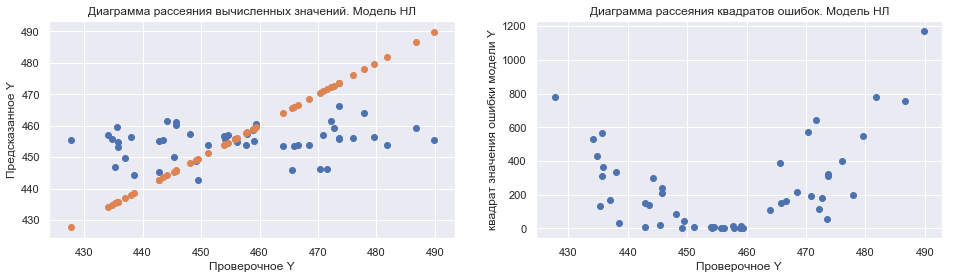

In [35]:
# вывод
data_part = data[target] [start_index:stop_index]
if (len (y_pred) == len (data_part)):
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    plt.scatter( data_part, y_pred.reshape(-1, 1) )
    plt.scatter( data_part, data_part,)
    plt.title(u'Диаграмма рассеяния вычисленных значений. Модель НЛ');
    plt.xlabel(u'Проверочное Y')
    plt.ylabel(u'Предсказанное Y')
    
    plt.subplot(122)
    plt.scatter( data_part, pow( data_part - y_pred.reshape(-1, 1), 2 ) )
    plt.title(u'Диаграмма рассеяния квадратов ошибок. Модель НЛ');
    plt.xlabel(u'Проверочное Y')
    plt.ylabel(u'квадрат значения ошибки модели Y')

else:
    print len (y_pred), len (data_part), "Размеры массивоов не совпадают"

In [36]:
r2 = metrics.r2_score( data_part, y_pred.reshape(-1, 1))

In [37]:
mae = metrics.mean_absolute_error(data_part, y_pred.reshape(-1, 1))

In [38]:
mse = metrics.mean_squared_error(data_part, y_pred.reshape(-1, 1))

In [39]:
print "r2  = {:>20.2f}".format(r2)
print "mae = {:>20.2f}".format(mae)
print "mse = {:>20.2f}".format(mse)

r2  =                 0.02
mae =                12.86
mse =               243.32


Попробуем улучшить результат

## Итерация 2

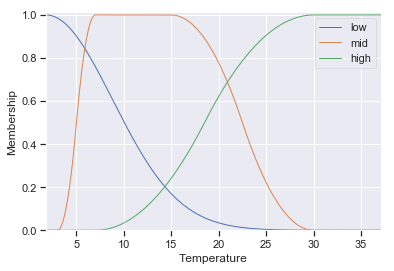

In [40]:
#Temperature
lv_temperature["low"] = fuzz.gaussmf(lv_temperature.universe, 1.81, 7)
lv_temperature["mid"] = fuzz.pimf(lv_temperature.universe, 3, 7, 15, 30)
lv_temperature["high"] = fuzz.pimf(lv_temperature.universe,7, 30, 60, 90)
lv_temperature.view()

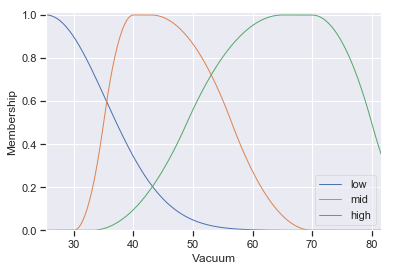

In [41]:
#Vacuum
lv_vacuum["low"] = fuzz.gaussmf(lv_vacuum.universe, 25.36, 10)
lv_vacuum["mid"] = fuzz.pimf(lv_vacuum.universe, 30, 40, 43, 70)
lv_vacuum["high"] = fuzz.pimf(lv_vacuum.universe, 33, 65, 70, 90)
lv_vacuum.view()

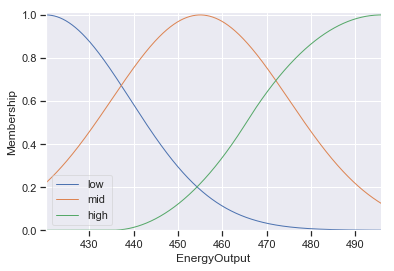

In [42]:
#EnergyOutput
lv_energyoutput["low"] = fuzz.gaussmf(lv_energyoutput.universe, 420.26, 19)
lv_energyoutput["mid"] = fuzz.gaussmf(lv_energyoutput.universe, 455,20)
lv_energyoutput["high"] = fuzz.smf(lv_energyoutput.universe, 435, 495.76)
lv_energyoutput.view()

## 2.4. Формирование нечеткой базы знаний

In [43]:
#1) ЕСЛИ () ИЛИ (), ТО ().
rule_1 = ctrl.Rule(
lv_temperature["low"] & lv_vacuum["low"] ,
lv_energyoutput["high"],
"firstRule")
#2) ЕСЛИ () ИЛИ (), ТО ().
rule_2 = ctrl.Rule(
lv_temperature["low"] & lv_vacuum["mid"] ,
lv_energyoutput["high"],
"secondRule")
#3) ЕСЛИ () ИЛИ (), ТО ().
rule_3 = ctrl.Rule(
lv_temperature["mid"] & lv_vacuum["mid"] ,
lv_energyoutput["low"],
"thirdRule")
#4) ЕСЛИ () ИЛИ (), ТО ().
rule_4 = ctrl.Rule(
lv_temperature["high"] & lv_vacuum["high"] ,
lv_energyoutput["low"],
"forthRule")
#5) ЕСЛИ () ИЛИ (), ТО ().
rule_5 = ctrl.Rule(
lv_temperature["mid"] & lv_vacuum["low"] ,
lv_energyoutput["high"],
"fifthRule")
#6) ЕСЛИ () ИЛИ (), ТО ().
rule_6 = ctrl.Rule(
lv_temperature["high"] & lv_vacuum["mid"] ,
lv_energyoutput["mid"],
"sixfthRule")
#7) ЕСЛИ () ИЛИ (), ТО ().
rule_7 = ctrl.Rule(
lv_temperature["mid"] & lv_vacuum["high"] ,
lv_energyoutput["mid"],
"sevnthRule")
#8) ЕСЛИ () ИЛИ (), ТО ().
rule_8 = ctrl.Rule(
lv_temperature["low"] & lv_vacuum["high"] ,
lv_energyoutput["high"],
"eightRule")

#9) ЕСЛИ () ИЛИ (), ТО ().
rule_9 = ctrl.Rule(
lv_temperature["high"] & lv_vacuum["low"] ,
lv_energyoutput["high"],
"nineRule")

## 2.5. Тестирование нечеткой базы знаний

### 2.5.1. Этап подготовки

In [44]:
quality_ctrl = ctrl.ControlSystem([rule_1, rule_2, rule_3, rule_4, rule_5, rule_6, rule_7, rule_8,rule_9])
quality_SIM = ctrl.ControlSystemSimulation(quality_ctrl)

In [45]:
# Создадим функцию для вывода степени вероятности принадлежности переданного значения
def printTerm(lingVal, value):
    print "\n  {:>10} = {:>10}".format(lingVal.label, value[0]),
    for term in lingVal.terms:
        print "{} {:>7} {:.2f},".format(" ", term, fuzz.interp_membership( lingVal.universe, lingVal[term].mf,   value[0])),

In [46]:
valid_size = 0.3 # доля тестовой части в выборке
rand_seed = 8 # начальное состояние генератора случ. чисел

x_train, x_test, y_train, y_test =  train_test_split(
    data[features], data[target], # исходные данные
    test_size = valid_size, 
    random_state=rand_seed, 
    shuffle=True # перемешивание
) 
print "Кол-во элементов: \n  x_train: {}, y_train {} \n  x_test:  {}, y_test  {} \n  total x: {}, total y {} ".format  (
    len(x_train), len(y_train),
    len(x_test),  len(x_test), 
    len(x_train)+len(x_test), len(y_train)+len(x_test),
)

Кол-во элементов: 
  x_train: 6697, y_train 6697 
  x_test:  2871, y_test  2871 
  total x: 9568, total y 9568 


### 2.5.2. Проверка работы модели

In [47]:
print "Вывод значений проверочной части данных"
start_index = 0
stop_index = 2
for i in range(start_index, stop_index):
    print "{}, {}; y:{}".format(
    x_test[features].iloc[i][0],
    x_test[features].iloc[i][1],y_test.iloc[i][0] )

Вывод значений проверочной части данных
12.64, 41.49; y:468.78
27.08, 62.91; y:442.91


In [48]:
in_temperatures = [12.64]
in_vacuumes = [41.49]

quality_SIM.input['Temperature'] = in_temperatures 
quality_SIM.input['Vacuum'] = in_vacuumes

print "Степень принадлежности значений к каждому терму:",
printTerm(lv_temperature, in_temperatures)
printTerm(lv_vacuum, in_vacuumes)

Степень принадлежности значений к каждому терму: 
  Temperature =      12.64       low 0.30,       mid 1.00,      high 0.12, 
      Vacuum =      41.49       low 0.27,       mid 1.00,      high 0.14,


In [49]:
# Вычисление
quality_SIM.compute()

# Вывод результата
print "calc={:,.2f}, real= {:,.2f}  delta={:,.2f}".format (quality_SIM.output['EnergyOutput'], y_test.iloc[1][0], (quality_SIM.output['EnergyOutput'] - y_test.iloc[1][0]))

calc=448.38, real= 442.91  delta=5.47


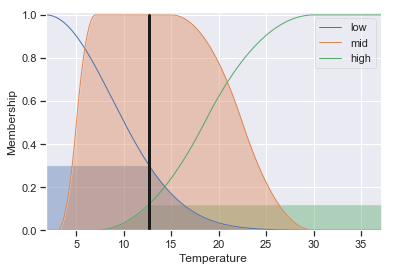

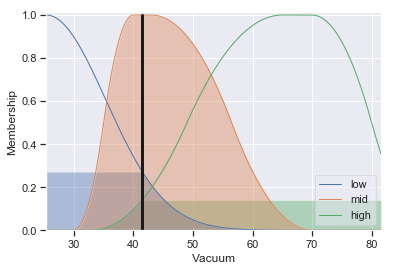

In [50]:
lv_temperature.view(sim=quality_SIM)
lv_vacuum.view(sim=quality_SIM)

In [51]:
quality_SIM.print_state()

 Antecedents 
Antecedent: Temperature             = [12.64]
  - low                             : [0.30215187]
  - mid                             : [1.]
  - high                            : [0.12026314]
Antecedent: Vacuum                  = [41.49]
  - low                             : [0.27229085]
  - mid                             : [1.]
  - high                            : [0.14078145]

 Rules 
RULE #0:
  IF Temperature[high] AND Vacuum[low] THEN EnergyOutput[high]
	AND aggregation function : fmin
	OR aggregation function  : fmax

  Aggregation (IF-clause):
  - Temperature[high]                                      : [0.12026314]
  - Vacuum[low]                                            : [0.27229085]
                         Temperature[high] AND Vacuum[low] = [0.12026314]
  Activation (THEN-clause):
                                        EnergyOutput[high] : [0.12026314]

RULE #1:
  IF Temperature[high] AND Vacuum[high] THEN EnergyOutput[low]
	AND aggregation function : fmin

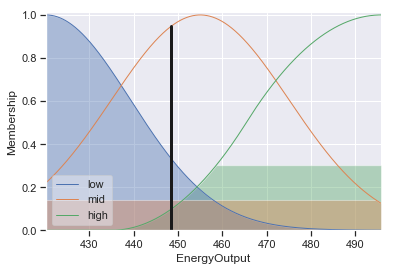

In [52]:
lv_energyoutput.view(sim=quality_SIM)

### 2.5.3. Проверка работы модели на проверочной части выборки

In [53]:
y_pred = np.array([])
start_index = 105
stop_index = 155

for i in range (start_index, stop_index):
    print "row", i,
    
    #очередные значения
    in_temperatures    = x_test[features].iloc[i][0],
    in_vacuum     = x_test[features].iloc[i][1], 
    out_energyoutput   = y_test.iloc[i][0]

    # задать значения в модель нечеткой логики
    quality_SIM.input['Temperature']     = in_temperatures
    quality_SIM.input['Vacuum'] = in_vacuum
    
    print "Степень принадлежности значений к каждому терму:",
    printTerm(lv_temperature, in_temperatures)
    printTerm(lv_vacuum, in_vacuum)
    
    # Вычисление
    quality_SIM.compute()

    # Вывод результата
    y_pred = np.append(y_pred, quality_SIM.output['EnergyOutput'])
    print ""
    print "{} calc={:.2f}, true={:.2f}".format(target[0], quality_SIM.output['EnergyOutput'], out_energyoutput) 
    print ""

row 105 Степень принадлежности значений к каждому терму: 
  Temperature =      15.56       low 0.15,       mid 1.00,      high 0.28, 
      Vacuum =       41.1       low 0.29,       mid 1.00,      high 0.13, 
EnergyOutput calc=448.04, true=464.42

row 106 Степень принадлежности значений к каждому терму: 
  Temperature =      28.98       low 0.00,       mid 0.01,      high 1.00, 
      Vacuum =      73.42       low 0.00,       mid 0.00,      high 0.94, 
EnergyOutput calc=435.80, true=432.20

row 107 Степень принадлежности значений к каждому терму: 
  Temperature =      16.83       low 0.10,       mid 0.97,      high 0.37, 
      Vacuum =      46.48       low 0.11,       mid 0.97,      high 0.35, 
EnergyOutput calc=448.53, true=455.64

row 108 Степень принадлежности значений к каждому терму: 
  Temperature =      23.19       low 0.01,       mid 0.41,      high 0.82, 
      Vacuum =      60.75       low 0.00,       mid 0.23,      high 0.96, 
EnergyOutput calc=450.07, true=439.43

row 109 

      Vacuum =      43.14       low 0.21,       mid 1.00,      high 0.20, 
EnergyOutput calc=455.82, true=483.49

row 143 Степень принадлежности значений к каждому терму: 
  Temperature =      26.65       low 0.00,       mid 0.10,      high 0.96, 
      Vacuum =      58.41       low 0.00,       mid 0.37,      high 0.92, 
EnergyOutput calc=448.82, true=442.66

row 144 Степень принадлежности значений к каждому терму: 
  Temperature =      26.92       low 0.00,       mid 0.08,      high 0.96, 
      Vacuum =      67.25       low 0.00,       mid 0.02,      high 1.00, 
EnergyOutput calc=439.41, true=434.05

row 145 Степень принадлежности значений к каждому терму: 
  Temperature =      14.65       low 0.19,       mid 1.00,      high 0.22, 
      Vacuum =      41.92       low 0.25,       mid 1.00,      high 0.16, 
EnergyOutput calc=446.78, true=464.95

row 146 Степень принадлежности значений к каждому терму: 
  Temperature =      22.36       low 0.01,       mid 0.52,      high 0.78, 
      Va

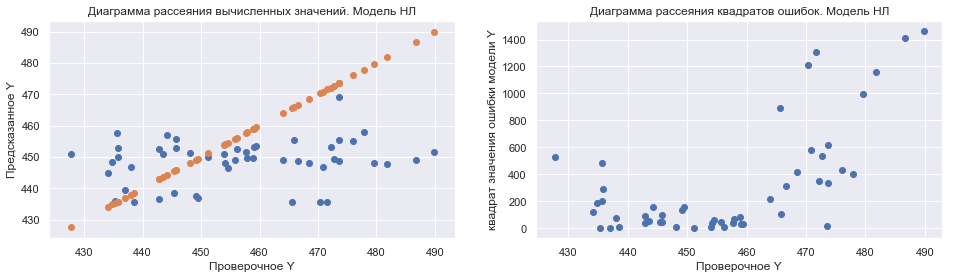

In [54]:
# вывод
data_part = data[target] [start_index:stop_index]
if (len (y_pred) == len (data_part)):
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    plt.scatter( data_part, y_pred.reshape(-1, 1) )
    plt.scatter( data_part, data_part,)
    plt.title(u'Диаграмма рассеяния вычисленных значений. Модель НЛ');
    plt.xlabel(u'Проверочное Y')
    plt.ylabel(u'Предсказанное Y')
    
    plt.subplot(122)
    plt.scatter( data_part, pow( data_part - y_pred.reshape(-1, 1), 2 ) )
    plt.title(u'Диаграмма рассеяния квадратов ошибок. Модель НЛ');
    plt.xlabel(u'Проверочное Y')
    plt.ylabel(u'квадрат значения ошибки модели Y')

else:
    print len (y_pred), len (data_part), "Размеры массивоов не совпадают"

In [55]:
r2 = metrics.r2_score( data_part, y_pred.reshape(-1, 1))

In [56]:
mae = metrics.mean_absolute_error(data_part, y_pred.reshape(-1, 1))

In [57]:
mse = metrics.mean_squared_error(data_part, y_pred.reshape(-1, 1))

In [58]:
print "r2  = {:>20.2f}".format(r2)
print "mae = {:>20.2f}".format(mae)
print "mse = {:>20.2f}".format(mse)

r2  =                -0.29
mae =                14.56
mse =               319.85


# Вывод

Было проведено несколько итераций, первая и последняя отображены в отчете. 
Получен положительный результат r2 = 0.02 на первой итерации. К сожалению, на последующей итерации не удалось его улучшить.
Улучшить модель можно проанализировав реальные и вычесленные результаты степени принадлежности и подправив соответствующие зависимости и правила. Также следует расширить диапазон проверяемых значений 